In [1]:
import os
import glob
import sys
import struct
import datetime
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from shapely.geometry import shape, mapping
from shapely.geometry.multipolygon import MultiPolygon
import fiona
import rasterio.features
import datetime 

import ipywidgets as widgets
# %matplotlib notebook
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

from IPython.display import clear_output

from lake import lake_extraction as le 
lake = le()

In [2]:
## Read the data 
band_2_fname = lake.traverse_data("*B2*.TIF")[0]
band_3_fname = lake.traverse_data("*B3*.TIF")[0]
band_4_fname = lake.traverse_data("*B4*.TIF")[0]
band_5_fname = lake.traverse_data("*B5*.TIF")[0]


band_2 = lake.read_data(band_2_fname)
band_3 = lake.read_data(band_3_fname)
band_4 = lake.read_data(band_4_fname)
band_5 = lake.read_data(band_5_fname)


print(datetime.datetime.now() - lake.start_time)


0:00:05.336457


Dropdown(description='List', options=('band_2', 'band_3', 'band_4', 'band_5'), value='band_2')

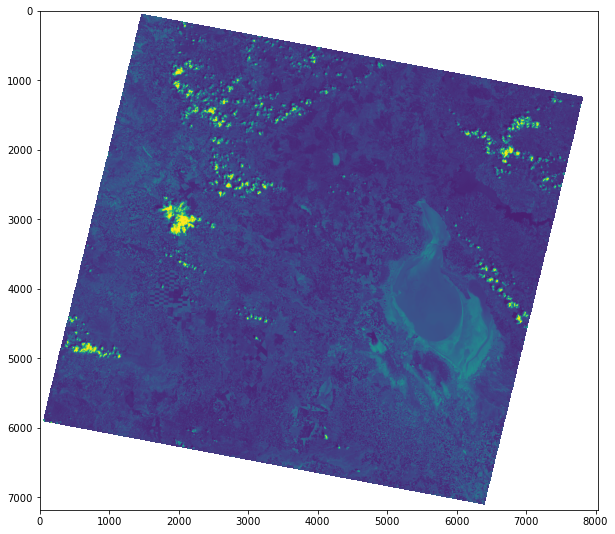

In [3]:
# Display band numbers 
plt.rcParams['figure.figsize'] = [10, 20]


mydata = {'band_2': band_2,
          'band_3': band_3,
          'band_4': band_4,
          'band_5': band_5,}

default = 'band_2'
plt.imshow(mydata[default])
w = widgets.Dropdown(
    options=mydata.keys(),
    value = default,
    description='List',
)

display(w)
def on_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        clear_output()
        display(w)
        # sns.boxplot(data = mydata[change['new']])
        plt.imshow(mydata[change['new']])

w.observe(on_change)

Dropdown(description='List', options=('ndvi', 'ndwi', 'ndbi', 'mndwi'), value='ndvi')

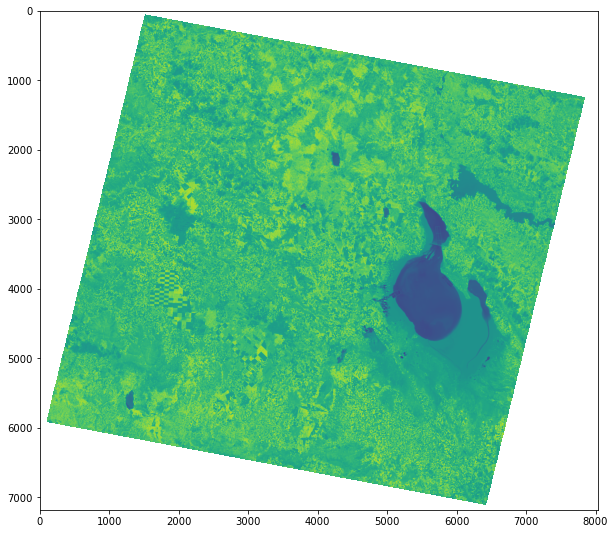

In [4]:
# Display band numbers 

ndvi = lake.calculate_ndvi(band_4, band_3)
ndwi = lake.calculate_ndwi(band_4, band_5)
ndbi = lake.calculate_ndbi(band_5, band_4)
mndwi = lake.calculate_mndwi(band_2, band_5)

# lake.export_index_to_raster(ndvi, "ndvi")
# lake.export_index_to_raster(ndbi, "ndbi")
# lake.export_index_to_raster(ndwi, "ndwi")
# lake.export_index_to_raster(mndwi, "mndwi")


plt.rcParams['figure.figsize'] = [10, 20]


mydata = {'ndvi': ndvi,
          'ndwi': ndwi,
          'ndbi': ndbi,
          'mndwi': mndwi,}

default = 'ndvi'
plt.imshow(mydata[default])
w = widgets.Dropdown(
    options=mydata.keys(),
    value = default,
    description='List',
)

display(w)
def on_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        clear_output()
        display(w)
        # sns.boxplot(data = mydata[change['new']])
        plt.imshow(mydata[change['new']])

w.observe(on_change)


In [5]:
from ipywidgets import HBox, Label
style = {'description_width': 'initial'}


a = widgets.IntSlider(description='NDVI', style=style, min=-1000, max=1000, step=1, value = 0 )
b = widgets.IntSlider(description='NDWI', style=style, min=-1000, max=1000, step=1, value = 400)
c = widgets.IntSlider(description='MNDWI', style=style, min=-1000, max=1000, step=1, value=400)
ui = widgets.HBox([ a, b, c])
def f(a, b, c):
    print(a)
    value = (ndvi < int(a)) & (ndwi > int(b)) & (mndwi> int(c))
    lake.export_index_to_raster(value, "lake")
    plt.imshow(value)
    print((a, b, c))

out = widgets.interactive_output(f, {'a': a, 'b': b, 'c': c})

display(ui, out)

Output()

In [6]:
polygon_name = "lake_in_ploygon"
lake.convert_to_polygon("lake", polygon_name)

In [7]:
import osr 
proj = osr.SpatialReference(wkt=lake.current_prj)


epsg_code_of_current_data = "EPSG:"+proj.GetAttrValue('AUTHORITY',1)

In [25]:

import pprint 
import pyproj
from shapely.ops import transform

from fiona.crs import from_epsg
crs = from_epsg(4326)
inProj = pyproj.Proj(init=epsg_code_of_current_data, preserve_units=True)
outProj = pyproj.Proj(init='epsg:4326')

g_data = None 

fname = os.path.join(lake.process_path, lake.output_folder, lake.current_shape_folder,polygon_name+".shp" )
fname_rep = os.path.join(lake.process_path, lake.output_folder, lake.current_shape_folder,polygon_name+"_rep.shp" )
from osgeo import ogr, osr
import os

driver = ogr.GetDriverByName('ESRI Shapefile')

# input SpatialReference
inSpatialRef = osr.SpatialReference()
inSpatialRef.ImportFromEPSG(int(proj.GetAttrValue('AUTHORITY',1)))

# output SpatialReference
outSpatialRef = osr.SpatialReference()
outSpatialRef.ImportFromEPSG(4326)

# create the CoordinateTransformation
coordTrans = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)

# get the input layer
inDataSet = driver.Open(fname)
inLayer = inDataSet.GetLayer()

# create the output layer
outputShapefile = fname_rep
if os.path.exists(outputShapefile):
    driver.DeleteDataSource(outputShapefile)
outDataSet = driver.CreateDataSource(outputShapefile)
outLayer = outDataSet.CreateLayer("lake_in_ploygon_rep", geom_type=ogr.wkbMultiPolygon)

# add fields
inLayerDefn = inLayer.GetLayerDefn()
for i in range(0, inLayerDefn.GetFieldCount()):
    fieldDefn = inLayerDefn.GetFieldDefn(i)
    outLayer.CreateField(fieldDefn)

# get the output layer's feature definition
outLayerDefn = outLayer.GetLayerDefn()

# loop through the input features
inFeature = inLayer.GetNextFeature()
while inFeature:
    # get the input geometry
    geom = inFeature.GetGeometryRef()
    # reproject the geometry
    geom.Transform(coordTrans)
    # create a new feature
    outFeature = ogr.Feature(outLayerDefn)
    # set the geometry and attribute
    outFeature.SetGeometry(geom)
    for i in range(0, outLayerDefn.GetFieldCount()):
        outFeature.SetField(outLayerDefn.GetFieldDefn(i).GetNameRef(), inFeature.GetField(i))
    # add the feature to the shapefile
    outLayer.CreateFeature(outFeature)
    # dereference the features and get the next input feature
    outFeature = None
    inFeature = inLayer.GetNextFeature()

# Save and close the shapefiles
inDataSet = None
outDataSet = None


from osgeo import ogr, osr

spatialRef = osr.SpatialReference()
spatialRef.ImportFromEPSG(4326)

spatialRef.MorphToESRI()
shp_file =  os.path.join(lake.process_path, lake.output_folder, lake.current_shape_folder,polygon_name+"_rep.prj" )
prj_file =  os.path.join(lake.process_path, lake.output_folder, lake.current_shape_folder,polygon_name+"_rep.prj" )

file = open(prj_file, 'w')
file.write(spatialRef.ExportToWkt())
file.close()


with fiona.open(fname_rep) as src:
    # pprint.pprint(src[1])
    
    g_data = src[1]
    

/usr/lib/python3/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/lib/python3/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/lib/python3/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https:/

In [26]:
from ipyleaflet import Map, basemaps,GeoJSON
import ipywidgets as ipyw
import geopandas as gpd

import geopandas as gpd
un_projected = gpd.read_file(fname)

import json 
json_name = os.path.join(lake.process_path, lake.output_folder, "lakes", "lakes.geojson" )
with open(json_name, 'r') as f:
    data = json.load(f)

# pprint(g_data)
#  pprint.pprint(g_data)

center = [38.128, 38.588]
zoom = 6

m = Map(basemap=basemaps.OpenStreetMap.Mapnik,center=center, zoom=zoom)
geo_json = GeoJSON(data=g_data)
m.add_layer(geo_json)
ipyw.VBox([m])
# Map(basemap=basemaps.OpenStreetMap.Mapnik, center=center, zoom=zoom)